In [18]:
# importing the required libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Task 1: Exploratory Data Analysis (EDA)

## Description of variables or features

### Bike Sharing Dataset Variables

| Variable Name | Role | Type | Description | Units | Missing Values |
|---------------|------|------|-------------|-------|----------------|
| instant | ID | Integer | Record index | - | no |
| dteday | Feature | Date | Date | - | no |
| season | Feature | Categorical | 1: winter, 2: spring, 3: summer, 4: fall | - | no |
| yr | Feature | Categorical | Year (0: 2011, 1: 2012) | - | no |
| mnth | Feature | Categorical | Month (1 to 12) | - | no |
| hr | Feature | Categorical | Hour (0 to 23) | - | no |
| holiday | Feature | Binary | Whether the day is a holiday (extracted from the official calendar) | - | no |
| weekday | Feature | Categorical | Day of the week | - | no |
| workingday | Feature | Binary | If the day is neither weekend nor holiday: 1, otherwise: 0 | - | no |
| weathersit | Feature | Categorical | 1: Clear, Few clouds, Partly cloudy, 2: Mist + cloudy, 3: Light snow/rain | - | no |
| temp | Feature | Continuous | Normalized temperature in Celsius, range: [–8, +39] | C | no |
| atemp | Feature | Continuous | Normalized feeling temperature in Celsius, range: [–16, +50] | C | no |
| hum | Feature | Continuous | Normalized humidity, values divided by 100 | - | no |
| windspeed | Feature | Continuous | Normalized wind speed, values divided by 67 | - | no |
| casual | Other | Integer | Count of casual users | - | no |
| registered | Other | Integer | Count of registered users | - | no |
| cnt | Target | Integer | Count of total rental bikes including both casual and registered users | - | no |


In [17]:
# loading the dataset
df = pd.read_csv('./bike+sharing+dataset/hour.csv')
display(df.head())

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Missing Record Analisis

In [10]:
# comparing the data vs the expected data

# 24 hours a day, 365 days a year, 2 years, 2011 and 2012 taking into account 2012 is a leap year
expected = (24*365) + (24*366)

# actual records in the dataset
actual = df.shape[0]
print('Data Shape:', actual)

# expected records for two year historical data 2011 and 2012
print('Expected records:', expected)

# hours missing
print('Missing:', expected-actual, 'hours', 'or', (expected-actual)/24, 'days')

Data Shape: 17379
Expected records: 17544
Missing: 165 hours or 6.875 days


In [28]:
def find_missing_hours(df):
    # Convert to datetime and filter for 2011 and 2012
    df['dteday'] = pd.to_datetime(df['dteday'])
    df = df[(df['dteday'].dt.year == 2011) | (df['dteday'].dt.year == 2012)]
    
    # Generate all possible dates for 2011 and 2012
    expected_dates = pd.date_range(start='2011-01-01', end='2012-12-31').date
    
    # Create complete set of expected date-hour combinations
    expected_combinations = set()
    for date in expected_dates:
        # Handle February 2012 (leap year)
        if date.year == 2012 and date.month == 2 and date.day == 29:
            for hour in range(24):
                expected_combinations.add((date, hour))
        else:
            # Verify valid date for non-leap years
            try:
                datetime(date.year, date.month, date.day)
                for hour in range(24):
                    expected_combinations.add((date, hour))
            except ValueError:
                continue
    
    # Create set of existing data
    existing_combinations = set(zip(df['dteday'].dt.date, df['hr']))
    
    # Find missing combinations
    missing = expected_combinations - existing_combinations
    
    # Organize results
    result = {}
    for date, hour in missing:
        if date not in result:
            result[date] = []
        result[date].append(hour)
    
    # Format output
    report = []
    for date in sorted(result.keys()):
        missing_hours = sorted(result[date])
        report.append({
            'Date': date.strftime('%Y-%m-%d'),
            'Missing Hours': missing_hours,
            'Total Missing Hours': len(missing_hours)
        })
    
    return pd.DataFrame(report)


result = find_missing_hours(df)
display(result.head())

,Date,Missing Hours,Total Missing Hours
0,2011-01-02,[5],1
1,2011-01-03,"[2, 3]",2
2,2011-01-04,[3],1
3,2011-01-05,[3],1
4,2011-01-06,[3],1


In [26]:
# total missing hours
total_missing_hours = result['Total Missing Hours'].sum()
print('Total Missing Hours:', total_missing_hours)

# days with more missing hours based on Missing Hours
display(result.sort_values(by='Total Missing Hours', ascending=False).head())


Total Missing Hours: 165


,Date,Missing Hours,Total Missing Hours
70,2012-10-29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",23
16,2011-01-27,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",16
71,2012-10-30,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",13
9,2011-01-18,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",12
15,2011-01-26,"[3, 4, 18, 19, 20, 21, 22, 23]",8


2012 es un año bisiesto deberia tener 236 dias

## Examine the target variable (cnt) distribution and identify its skewness

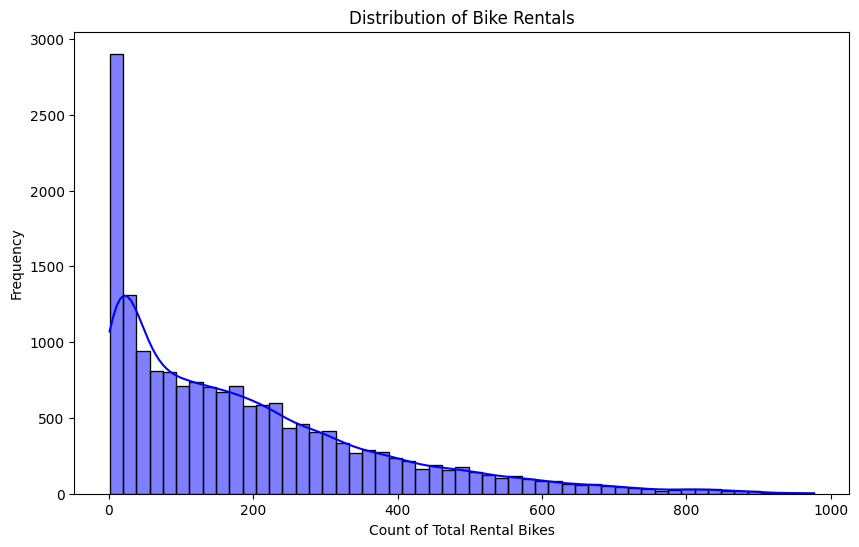

In [33]:
# ploting cnt histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['cnt'], kde=True, color='blue')
plt.title('Distribution of Bike Rentals')
plt.xlabel('Count of Total Rental Bikes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# checking for missing records



Initial dataset Analisis